# Clasificación de dígitos usando Redes Convolucionales y Keras

## 1 - El set de datos

En este tutorial implementaremos una red convolucional capaz de clasificar los dígitos del 0 al 9. Para ello usaremos el set de datos [MNIST](http://yann.lecun.com/exdb/mnist/), que contiene un total de 70.000 imágenes escritas a mano por diferentes personas.

![Algunos ejemplos de imágenes provenientes del set MNIST](MNIST_ejemplo.png)

Al final de este tutorial tendremos claro:
1. Cómo funciona [LeNet-5](http://yann.lecun.com/exdb/lenet/), la red convolucional usada en este tutorial
2. Cómo implementar esta red convolucional usando la librería Keras
3. Cómo evaluar el desempeño de la red

En primer lugar, veamos cómo es LeNet-5.

## 2 - LeNet-5

Esta red es la precursora de todas las redes convolucionales usadas en la actualidad. Fue diseñada por [Yann LeCun] a finales de los años 90, con el fin de clasificar dígitos (del 0 al 9) escritos a mano.

Esta red tiene como entradas imágenes de 28x28x1: 28 filas, 28 columnas y 1 sólo plano de color, es decir imágenes en escala de gris.

![LeNet-5](LeNet5.png)

Como se observa en la figura de arriba, la red cuenta con dos bloques de procesamiento:
- Las *capas convolucionales* que se encargan de extraer características de las imágenes
- La *red neuronal*, que toma dichas características y permite clasificar la imagen en uno de los posibles 10 dígitos (del 0 al 9)

Además, podemos observar las siguientes características:
- Después de realizar convoluciones se usa siempre la función de activación *ReLU*
- El *max-pooling* se realiza después de las convoluciones
- Las *dimensiones espaciales* (número de filas y columnas) de las imágenes se reducen entre una capa y otra, mientras que la profundidad (correspondiente a las características extraídas) aumenta entre una capa y otra

Las redes convolucionales usadas en la actualidad implementan una lógica similar a la de LeNet-5.

## 3 - Implementación en Keras

### 3.1 - Librerías requeridas

En primer lugar se importa la librería Numpy y se ajusta la semilla del generador aleatorio para garantizar la reproducibilidad del entrenamiento. También importaremos la librería Matplotlib, para poder visualizar las imágenes del set de datos :

In [1]:
import os
import numpy as np
import random as rn

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

import matplotlib.pyplot as plt
%matplotlib notebook

A continuación importamos las funciones *Sequential*, *Conv2D*, *MaxPooling2D*, *Flatten*, *Dense* y *SGD* de Keras:

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.optimizers import SGD

Using TensorFlow backend.


### 3.2 - Pre-procesamiento del set de datos

La función *mnist* de Keras permite leer el set de datos y crear automáticamente los sets de entrenamiento y validación. El primero de ellos tendrá 60,000 imágenes (cada una de 28x28) con sus correspondientes categorías, mientras que el segundo tendrá 10,000 datos:

In [3]:
(x_train, y_train), (x_test,y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Los pixeles en las imágenes (tanto de entrenamiento como de validación) tienen valores entre 0 y 255; sin embargo, para garantizar la convergencia del entrenamiento es necesario normalizar estos valores entre 0 y 1:

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

También se deben codificar *y_train* y *y_test* en el formato *one-hot*:

In [5]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [6]:
nclases = 10
y_train = np_utils.to_categorical(y_train,nclases)
y_test = np_utils.to_categorical(y_test,nclases)

y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Finalmente, podemos visualizar un ejemplo de imagen dentro del dataset:

(-0.5, 27.5, 27.5, -0.5)

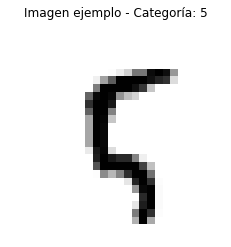

In [7]:
nimagen = 100
plt.imshow(x_train[nimagen,:].reshape(28,28), cmap='gray_r')
plt.title('Imagen ejemplo - Categoría: ' + str(np.argmax(y_train[nimagen])))
plt.axis('off')

Por defecto, Keras requiere cada dato de entrada en el formato nimagenes x nfilas x ncolumnas x ncanales, donde ncanales = 1 por ser imágenes en escala de gris. Se debe modificar el tamaño de *x_train* y *x_test* para cumplir con este requerimiento:

In [8]:
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 3.3 - Creación del modelo

En la siguiente tabla se resumen las características de cada capa a implementar:
    
| **Capa**          | **Características**                            |
|-------------------|------------------------------------------------|
| CONV 1            | 6 filtros, 5x5, p=0, s=1, activación: ReLU     |
| MAX-POOLING 1     | 6 filtros, 2x2, p=0, s=2, activación: Ninguna  |
| CONV 2            | 16 filtros, 5x5, p=0, s=1, activación: ReLU    |
| MAX-POOLING 2     | 16 filtros, 2x2, p=0, s=2, activación: Ninguna |
| FLATTEN           | Simplemente convierte un volumen en un vector  |
| FULLY CONNECTED 1 | 120 neuronas, activación: ReLU                 |
| FULLY CONNECTED 2 | 84 neuronas, activación: ReLU                  |
| SALIDA            | 10 categorías, activación: softmax             |



Creemos el contenedor del modelo usando *Sequential()*:

In [9]:
modelo = Sequential()

Y añadimos, de forma secuencial, las diferentes capas de la red convolucional. En particular, usamos *Conv2D* para las capas convolucionales y *MaxPooling2D* para el *max-pooling*, junto con *Flatten* y *Dense* para la etapa de clasificación con redes neuronales y la capa de salida:

In [10]:
# CONV1 Y MAX-POOLING1
modelo.add(
    Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(28,28,1))
)
modelo.add(
    MaxPooling2D(pool_size=(2,2))
)

# CONV2 Y MAX-POOLING2
modelo.add(
    Conv2D(filters=16, kernel_size=(5,5), activation='relu')
)
modelo.add(
    MaxPooling2D(pool_size=(2,2))
)

# Aplanar, FC1, FC2 y salida
modelo.add(
    Flatten()
)
modelo.add(
    Dense(120,activation='relu')
)
modelo.add(
    Dense(84,activation='relu')
)
modelo.add(
    Dense(nclases,activation='softmax')
)

In [11]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

### 3.4 - Compilación del modelo

En esta etapa definimos el optimizador a usar (gradiente descendente, tasa de aprendizaje = 0.1), así como la función de error (entropía cruzada) y la métrica de desempeño (precisión):

In [12]:
sgd = SGD(lr=0.1)
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### 3.5 - Entrenamiento

Realicemos el entrenamiento usando 10 iteraciones, una tasa de aprendizaje de 0.1 y un tamaño de lote (*batch_size*) de 128:

In [13]:
nepochs = 10
tam_lote = 128
modelo.fit(
    x_train, y_train,
    epochs=nepochs,
    batch_size=tam_lote, 
    verbose=1, 
    validation_data=(x_test,y_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 16s 269us/step - loss: 0.3641 - accuracy: 0.8858 - val_loss: 0.1117 - val_accuracy: 0.9630
Epoch 2/10
60000/60000 [==============================] - 16s 261us/step - loss: 0.0913 - accuracy: 0.9717 - val_loss: 0.0630 - val_accuracy: 0.9806
Epoch 3/10
60000/60000 [==============================] - 16s 259us/step - loss: 0.0665 - accuracy: 0.9786 - val_loss: 0.0534 - val_accuracy: 0.9818
Epoch 4/10
60000/60000 [==============================] - 16s 270us/step - loss: 0.0507 - accuracy: 0.9841 - val_loss: 0.0596 - val_accuracy: 0.9808
Epoch 5/10
60000/60000 [==============================] - 16s 263us/step - loss: 0.0422 - accuracy: 0.9866 - val_loss: 0.0394 - val_accuracy: 0.9869
Epoch 6/10
60000/60000 [==============================] - 16s 261us/step - loss: 0.0370 - accuracy: 0.9880 - val_loss: 0.0409 - val_accuracy: 0.9869
Epoch 7/10
60000/60000 [==============================] 

Vemos que en la última iteración, el modelo alcanza una precisión de 99.3% para el set de entrenamiento y del 98.6% para el set de validación. Esta precisión nos indica que, en promedio, de cada 100 datos, aproximadamente 1 es clasificado incorrectamente. !Nada mal!

## 4 - Desempeño del modelo

La precisión obtenida anteriormente es una medida de desempeño global de la red convolucional, pero no nos permite verificar si algunos dígitos resultan mejor clasificados que otros. Para analizar en detalle este comportamiento, podemos usar la matriz de confusión:

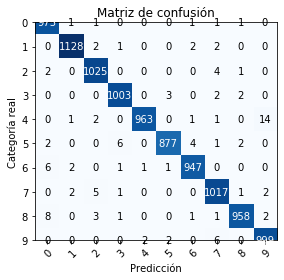

In [15]:
from matriz_confusion import graficar_matriz_de_confusion

y_pred = modelo.predict_classes(x_test)
y_ref = np.argmax(y_test,axis=1)
etiquetas = ['0','1','2','3','4','5','6','7','8','9']
graficar_matriz_de_confusion(y_ref, y_pred, etiquetas)